In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats  # Add this import at the top of your code
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Basic EDA
def explore_data(df):
    print("\nBasic Information:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe(include='all'))
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDuplicate Rows:", df.duplicated().sum())

    # Display unique values for categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        print(f"\nUnique values in {col}:")
        print(df[col].value_counts())

In [ ]:
# Pairwise plot color-coded by test status
def pairwise_plot(df, hue_col):
    numeric_cols = df.select_dtypes(include=['number']).columns
    sns.pairplot(df, vars=numeric_cols, hue=hue_col, palette='tab10')
    plt.show()

In [ ]:
# Pearson correlation heatmap
def correlation_heatmap(df):
    numeric_df = df.select_dtypes(include=['number'])
    if not numeric_df.empty:
        # Calculate the correlation matrix
        corr_matrix = numeric_df.corr()
        # Plot the heatmap without the values in the cells
        fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
        fig.patch.set_alpha(0)  # Transparent figure background
        ax.set_facecolor('none')  # Transparent axis background

        # Create heatmap
        ax = sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)

        # Set bold font for labels
        ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)

        # Set title with bold font
        #plt.title("Feature Correlation Heatmap", fontweight='bold', fontsize=12)

        # Set bold font for colorbar labels
        colorbar = ax.collections[0].colorbar
        colorbar.ax.yaxis.set_tick_params(labelsize=12)
        for label in colorbar.ax.get_yticklabels():
            label.set_fontweight('bold')
        plt.show()
        #print(corr_matrix)
    else:
        print("No numeric columns available for correlation heatmap.")

In [ ]:
#Load data
file_path = "/content/drive/My Drive/CHE-696Project/Dataset/processed_well_data.csv"
df = pd.read_csv(file_path)

In [ ]:
#Basic EDA (Stats)
#explore_data(df)

In [ ]:
#Data distribution based on well condition
test_status_counts = df['Test status'].value_counts()
# Plot the bar graph
plt.figure(figsize=(3, 3))
sns.barplot(x=test_status_counts.index, y=test_status_counts.values)
plt.title('Frequency of Test Status Categories')
#plt.xlabel('Test Status')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

In [ ]:
columns_to_drop = ['GasVis', 'LiqVis', 'g (m/s2)']  # Specify columns to drop
df_filtered = df.drop(columns=columns_to_drop, errors='ignore')

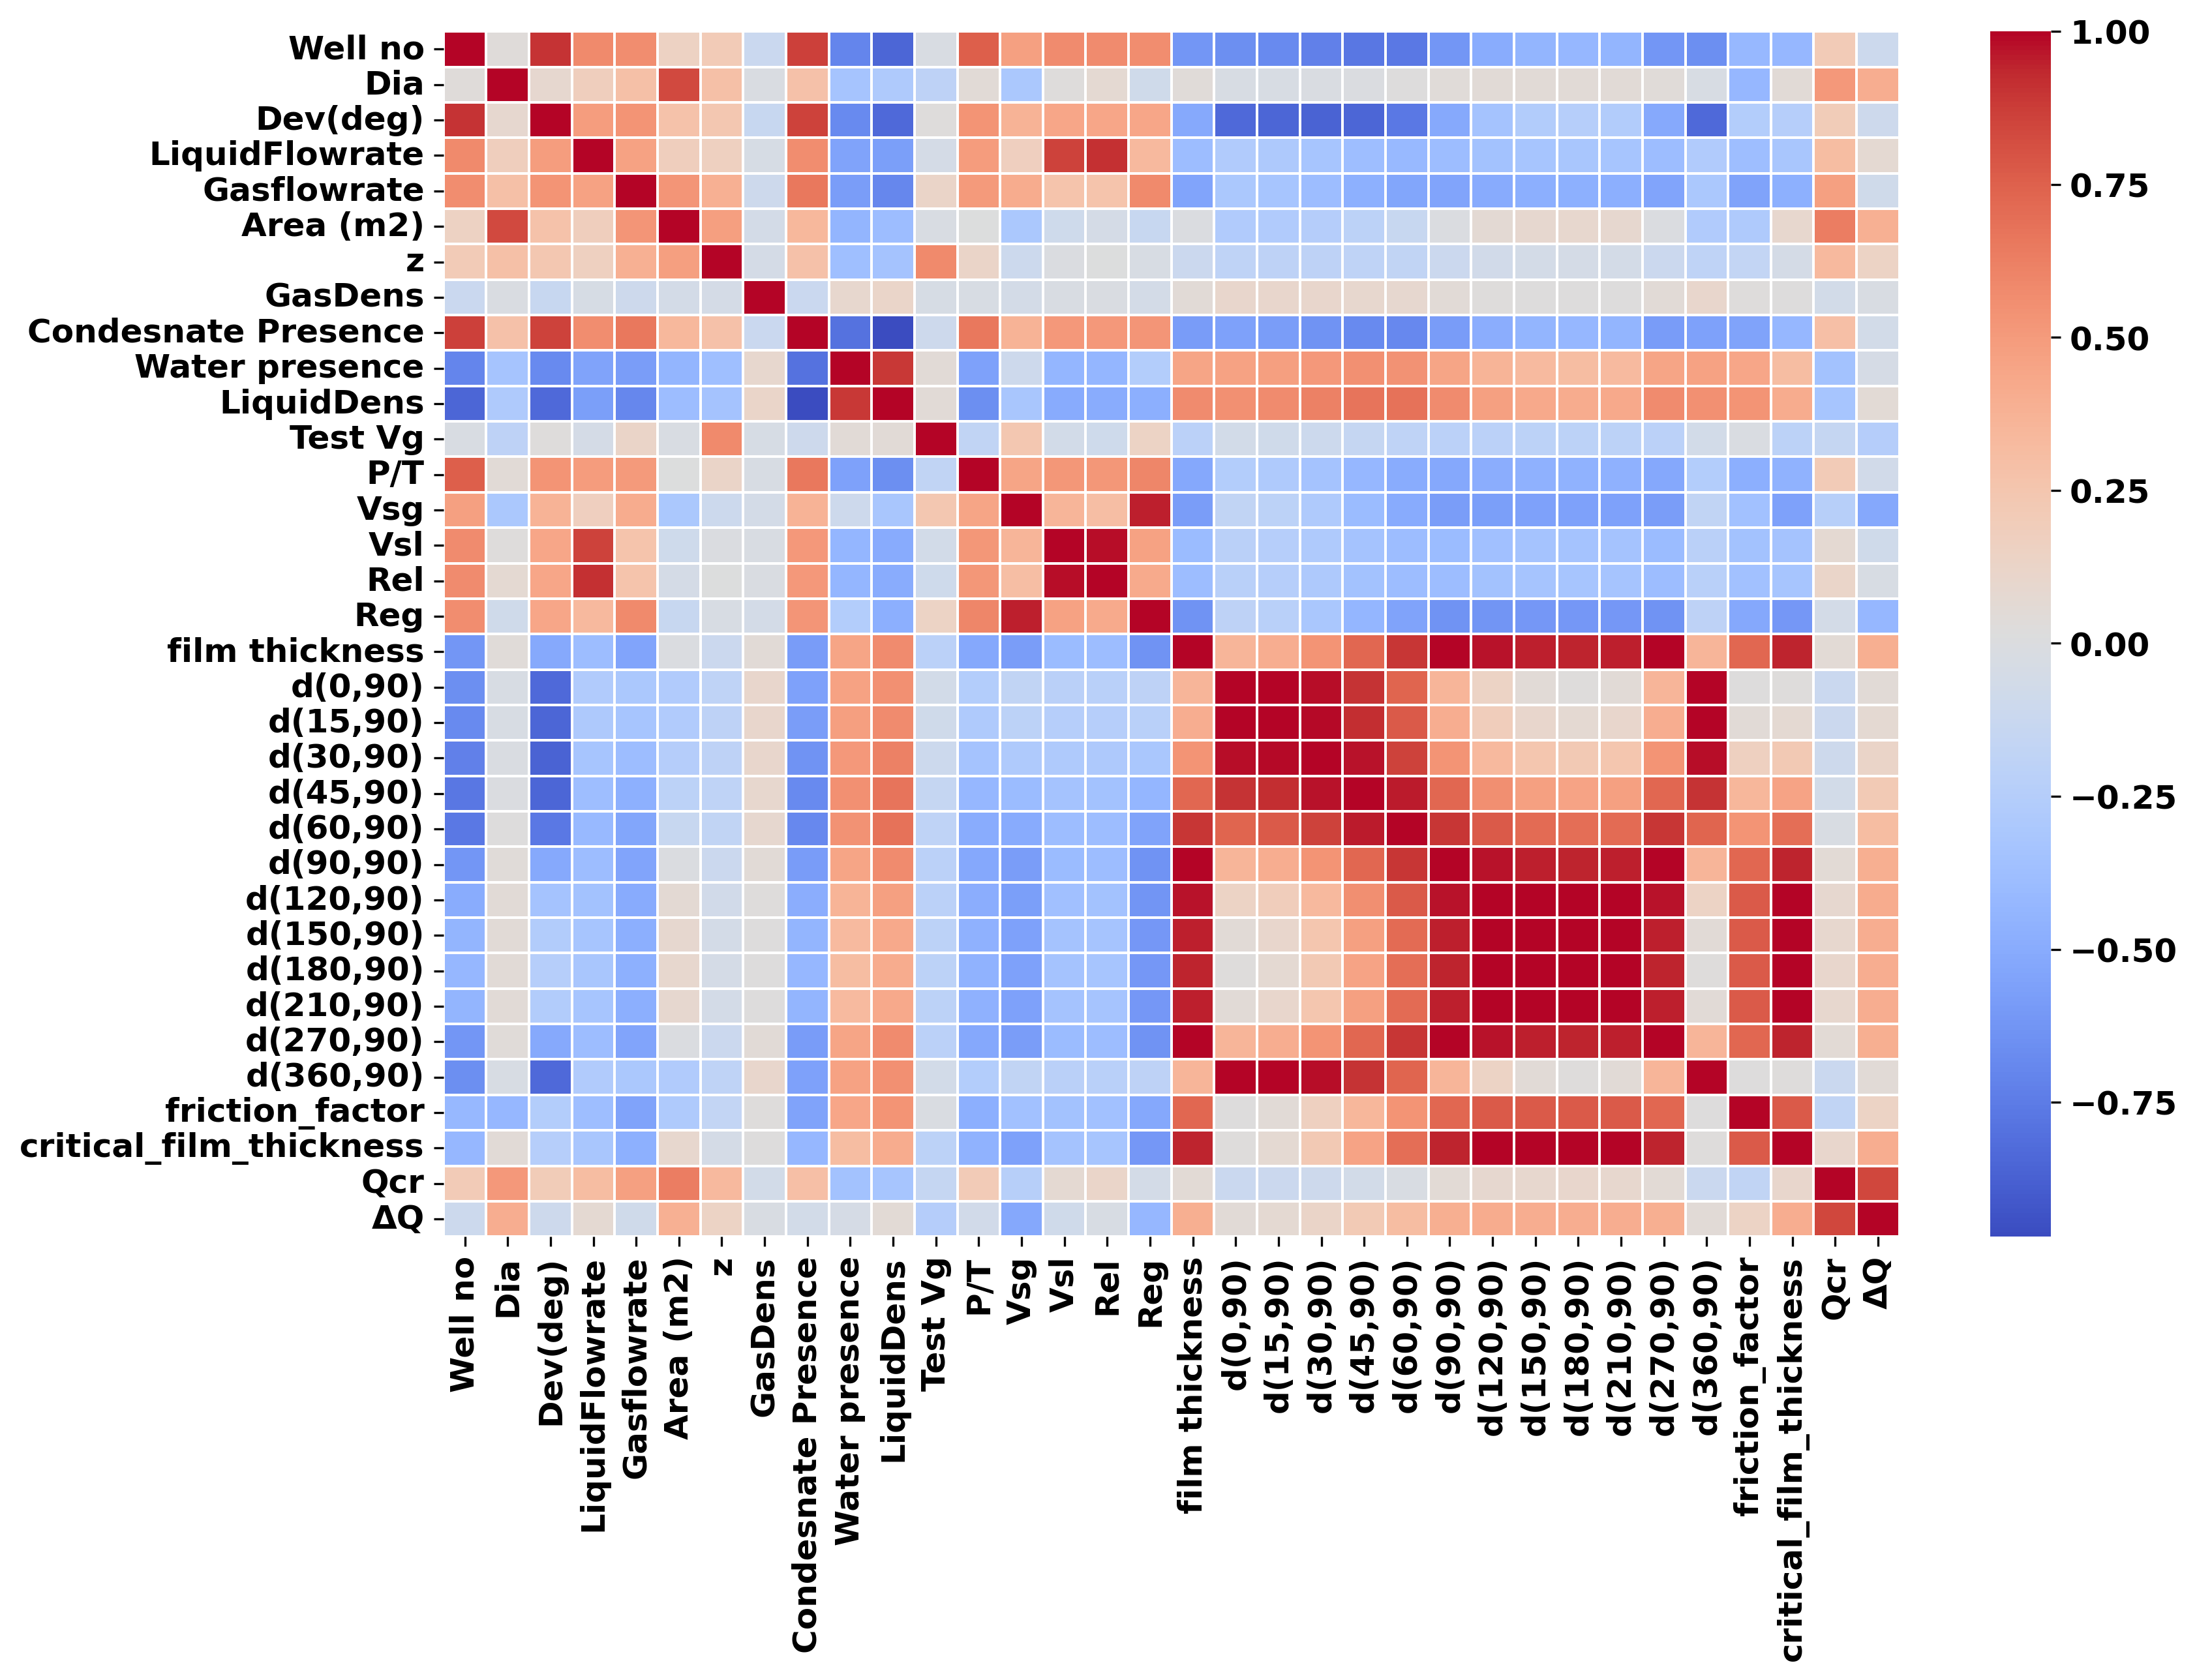

In [ ]:
#Pearson correlation heatmap
correlation_heatmap(df_filtered)

In [ ]:
#Pairwise plots
pairwise_plot(df_filtered, "Test status")  # Adjust column name if needed

Enhanced Data Distribution Analysis

In [ ]:
##Enhanced Data Distribution Analysis
def enhanced_distribution_analysis(df):
    # Numerical features distribution with test status
    num_cols = df.select_dtypes(include=['number']).columns
    plt.figure(figsize=(15, 10))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(4, 4, i)
        sns.boxplot(x='Test status', y=col, data=df)
        plt.title(f'{col} by Test Status')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Categorical features distribution
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 1:  # excluding 'Test status' if it's categorical
        for col in cat_cols:
            if col != 'Test status':
                plt.figure(figsize=(8, 4))
                sns.countplot(x=col, hue='Test status', data=df)
                plt.title(f'{col} Distribution by Test Status')
                plt.xticks(rotation=45)
                plt.show()

Outlier Detection

In [ ]:
##Outlier Detection
def detect_outliers(df):
    num_cols = df.select_dtypes(include=['number']).columns
    plt.figure(figsize=(15, 8))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(3, 4, i)
        sns.boxplot(y=df[col])
        plt.title(f'Outliers in {col}')
    plt.tight_layout()
    plt.show()


Principal Component Analysis and Statistical Testing

In [ ]:
##Principal Component Analysis
def pca_analysis(df, target_col='Test status'):
    # Convert categorical target to numerical if needed
    if df[target_col].dtype == 'object':
        df[target_col] = df[target_col].astype('category').cat.codes

    # Select features and standardize
    X = df.select_dtypes(include=['number']).drop(columns=[target_col], errors='ignore')
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA()
    principal_components = pca.fit_transform(X_scaled)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_),
             marker='o', linestyle='--')
    plt.title('Explained Variance by Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)
    plt.grid()
    plt.show()

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(data=principal_components[:, :2],
                          columns=['PC1', 'PC2'])
    pca_df[target_col] = df[target_col].values

    # Plot the PCA components
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue=target_col, data=pca_df, palette='viridis')
    plt.title('PCA - First Two Principal Components')
    plt.show()

    return pca

## Statistical Testing
def statistical_tests(df, target_col='Test status'):
    # Convert categorical target to numerical if needed
    if df[target_col].dtype == 'object':
        df[target_col] = df[target_col].astype('category').cat.codes

    # Select numerical features
    num_cols = df.select_dtypes(include=['number']).columns

    # ANOVA test for each feature against target
    print("\nANOVA Results (Feature vs Target):")
    for col in num_cols:
        if col != target_col:
            groups = [df[col][df[target_col] == category] for category in df[target_col].unique()]
            f_val, p_val = stats.f_oneway(*groups)
            print(f"{col}: F-value = {f_val:.3f}, p-value = {p_val:.4f}")

In [ ]:
#Enhanced distribution analysis
enhanced_distribution_analysis(df_filtered)

#Outlier detection
detect_outliers(df_filtered)

#PCA analysis
pca = pca_analysis(df_filtered)

#Statistical tests
statistical_tests(df_filtered)

Function to optimise the hyperparameters for both LASSO and Ridge

In [ ]:
def regularization_analysis(df, target_col='Test status'):
    """
    Perform Lasso (L1) and Ridge (L2) regression for feature importance analysis with hyperparameter optimization.
    Returns high-resolution plots with transparent background, bold labels (font size 12) and zero axis lines.
    """
    # Convert categorical target to numerical if needed
    if df[target_col].dtype == 'object':
        df[target_col] = df[target_col].astype('category').cat.codes

    X = df.select_dtypes(include=['number']).drop(columns=[target_col], errors='ignore')
    y = df[target_col]

    # Split and scale the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

    # Parameter grid for optimization
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 20, 40, 80, 160]}

    # Function to perform grid search and return the best estimator
    def optimize_model(model):
        model_cv = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
        model_cv.fit(X_train_scaled, y_train)
        return model_cv.best_estimator_

    best_lasso, best_ridge = optimize_model(Lasso()), optimize_model(Ridge())

    # Calculate MSE for both models
    lasso_train_mse = mean_squared_error(y_train, best_lasso.predict(X_train_scaled))
    lasso_test_mse = mean_squared_error(y_test, best_lasso.predict(X_test_scaled))
    ridge_train_mse = mean_squared_error(y_train, best_ridge.predict(X_train_scaled))
    ridge_test_mse = mean_squared_error(y_test, best_ridge.predict(X_test_scaled))

    # Plot feature coefficients with high resolution and styling
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['font.size'] = 12  # Set base font size
    plt.rcParams['savefig.transparent'] = True  # Enable transparent background

    # Create figure with transparent facecolor
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), dpi=300, facecolor='none')

    # Lasso plot
    lasso_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_lasso.coef_})
    lasso_df = lasso_df.sort_values('Coefficient', ascending=False)
    sns.barplot(x='Coefficient', y='Feature', data=lasso_df, palette="coolwarm", ax=axes[0])
    axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
    axes[0].set_title(f'Lasso (L1) Coefficients - Best Alpha: {best_lasso.alpha:.3f}', pad=20, fontsize=12)
    axes[0].set_xlabel('Coefficient Value', labelpad=10, fontsize=12)
    axes[0].set_ylabel('Features', labelpad=10, fontsize=12)
    axes[0].set_facecolor('none')  # Transparent plot background

    # Ridge plot
    ridge_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_ridge.coef_})
    ridge_df = ridge_df.sort_values('Coefficient', ascending=False)
    sns.barplot(x='Coefficient', y='Feature', data=ridge_df, palette="coolwarm", ax=axes[1])
    axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
    axes[1].set_title(f'Ridge (L2) Coefficients - Best Alpha: {best_ridge.alpha:.3f}', pad=20, fontsize=12)
    axes[1].set_xlabel('Coefficient Value', labelpad=10, fontsize=12)
    axes[1].set_ylabel('', fontsize=12)
    axes[1].set_facecolor('none')  # Transparent plot background

    # Adjust layout and make text bold with font size 12
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontweight('bold')
            item.set_fontsize(12)
        ax.grid(axis='x', linestyle=':', alpha=0.7)
        # Make spines (axis lines) visible against transparent background
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(0.5)

    plt.tight_layout()
    plt.show()

    # Print results
    print(f"Best Lasso Alpha: {best_lasso.alpha:.4f}, Train MSE: {lasso_train_mse:.4f}, Test MSE: {lasso_test_mse:.4f}")
    print(f"Best Ridge Alpha: {best_ridge.alpha:.4f}, Train MSE: {ridge_train_mse:.4f}, Test MSE: {ridge_test_mse:.4f}")

    # Feature importance sorted by absolute Lasso coefficients
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Lasso_Coeff': best_lasso.coef_,
        'Ridge_Coeff': best_ridge.coef_,
        'Lasso_Abs_Coeff': abs(best_lasso.coef_),
        'Ridge_Abs_Coeff': abs(best_ridge.coef_)
    }).sort_values(by='Lasso_Abs_Coeff', ascending=False)

    print("\nFeature Importance (Based on Lasso Coefficients):")
    print(feature_importance[['Feature', 'Lasso_Coeff', 'Ridge_Coeff']].to_string(index=False))

    return best_lasso, best_ridge, (lasso_train_mse, lasso_test_mse), (ridge_train_mse, ridge_test_mse)

L1 and L2 regularisation + Feature importance

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.442e-02, tolerance: 2.603e-02
  model = cd_fast.enet_coordinate_descent(
<ipython-input-35-309ba4013bbd>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=lasso_df, palette="coolwarm", ax=axes[0])
<ipython-input-35-309ba4013bbd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=ridge_df, palette="coolwarm", ax=axes[1])


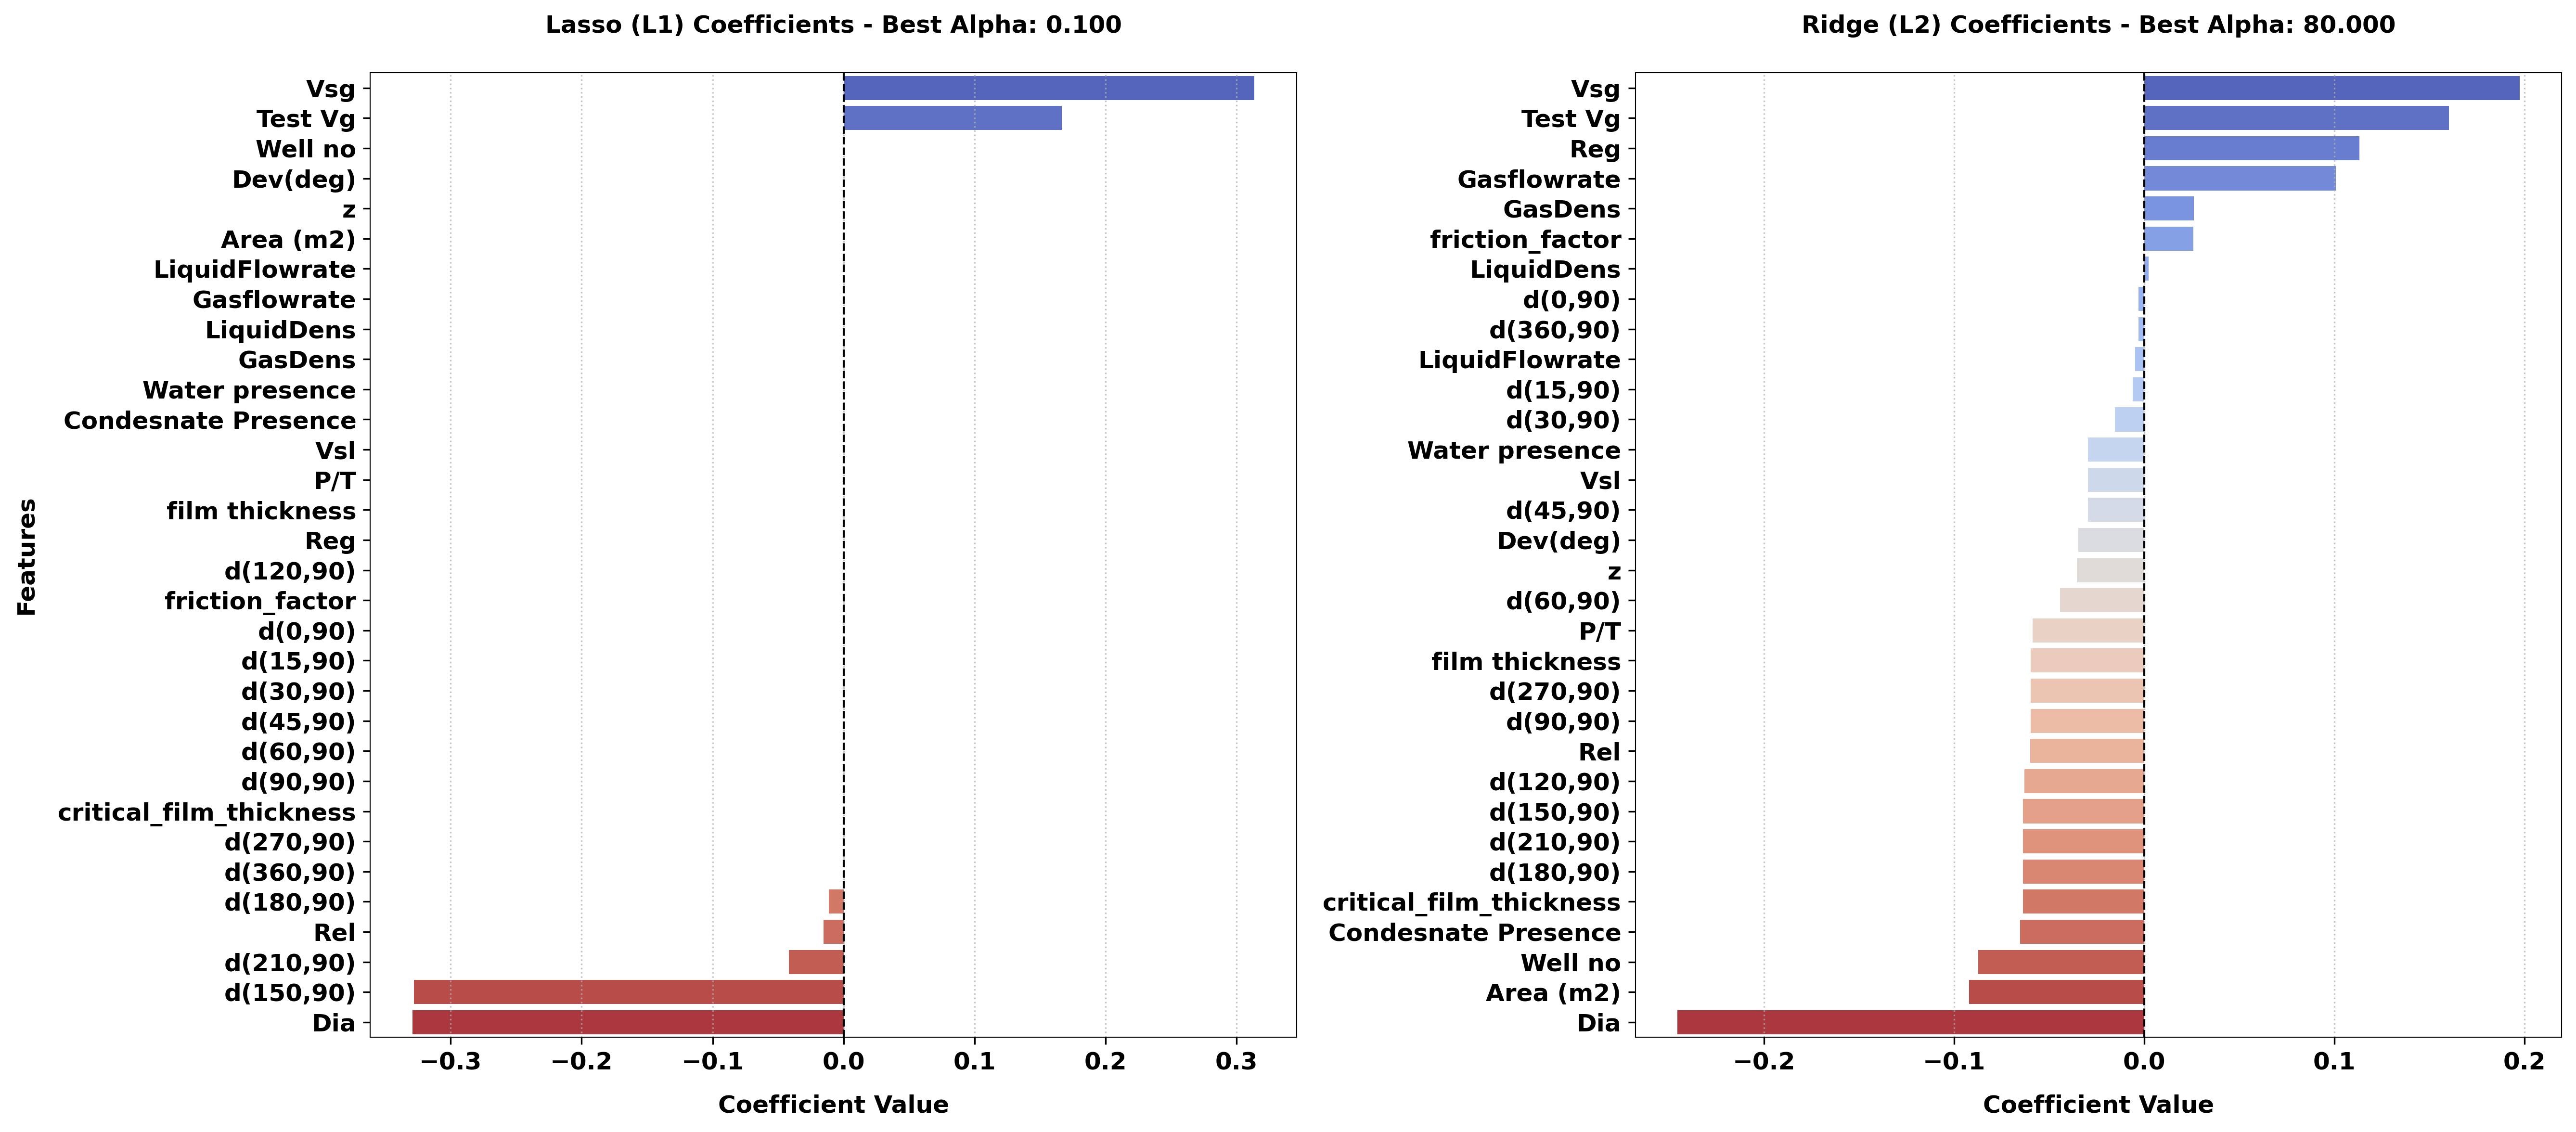

Best Lasso Alpha: 0.1000, Train MSE: 1.0516, Test MSE: 1.4191
Best Ridge Alpha: 80.0000, Train MSE: 1.0021, Test MSE: 1.4980

Feature Importance (Based on Lasso Coefficients):
                Feature  Lasso_Coeff  Ridge_Coeff
                    Dia    -0.329117    -0.245554
              d(150,90)    -0.327899    -0.063740
                    Vsg     0.313643     0.197271
                Test Vg     0.166494     0.160282
              d(210,90)    -0.041721    -0.063740
                    Rel    -0.015341    -0.060002
              d(180,90)    -0.011379    -0.063818
            Gasflowrate     0.000000     0.100801
                GasDens     0.000000     0.026127
                      z    -0.000000    -0.035366
              Area (m2)    -0.000000    -0.092063
    Condesnate Presence    -0.000000    -0.065263
             LiquidDens     0.000000     0.002245
                Well no    -0.000000    -0.087274
               Dev(deg)    -0.000000    -0.034777
         LiquidFlowrate 

In [ ]:
# Assuming df_filtered is your DataFrame containing both features and target
df_regular = df_filtered.iloc[:, :-2] #drop last 2 columns=['Qcr', '𝚫Q']
lasso_model, ridge_model, lasso_mse, ridge_mse = regularization_analysis(df_regular, target_col='Test status')